In [2]:
# @title 1. Instalación de Librerías
print("🚀 Iniciando instalación del entorno HTR Inteligente...")

import subprocess
import sys

def install(package):
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])

try:
    # Instalar lo necesario
    install("easyocr")
    install("opencv-python-headless")
    install("numpy")
    install("matplotlib")
    print("✅ Librerías instaladas correctamente.")

except Exception as e:
    print(f"❌ Error en la instalación: {e}")

print("\n✨ ENTORNO LISTO. Pasa a la siguiente celda.")

🚀 Iniciando instalación del entorno HTR Inteligente...
✅ Librerías instaladas correctamente.

✨ ENTORNO LISTO. Pasa a la siguiente celda.


In [3]:
# @title 2. Carga del Modelo HTR v9 (Filtro de Filas Vacías)
import sys
import os
import cv2
import easyocr
import numpy as np
import json
import re
import difflib
from google.colab import files, drive
import matplotlib.pyplot as plt
from datetime import datetime

print("🧠 Cargando Lógica HTR Inteligente...")

# ==================================================================================
# 1. CONTEXTO (Base de datos de Nombres/Lugares)
# ==================================================================================
class BolivianContext:
    def __init__(self):
        # Diccionario Híbrido (Manuscrito + Impreso)
        self.APELLIDOS = [
            "QUISPE", "MAMANI", "FLORES", "CONDORI", "CHOQUE", "VARGAS", "GUTIERREZ",
            "ROJAS", "LOPEZ", "CRUZ", "ALIAGA", "COLQUE", "OROZCO", "CHURQUI",
            "LANDAETA", "CHAVEZ", "COLLAO", "LUNA", "BUSTILLOS", "CHACON", "CUTILI",
            "LINARES", "PATI", "ARGANDOÑA", "DELGADILLO", "ESPEJO", "SIRPA", "PRIMY",
            "MENDIETA", "AGUILERA", "PALMA", "LLAMPA", "CALLISAYA", "GONZALES",
            "TANGARA", "RODRIGUEZ", "MORALES", "RIVERO", "SIÑANI", "URIARTE", "SUXO",
            "CARREÑO", "LIMA", "ESPADA", "LARREA", "ORMACHEA", "ALVAREZ", "PEREZ",
            "MARIACA", "ESTRADA", "GUACHALLA", "VERA", "MARQUEZ", "ANCASI", "PARI",
            "ALABY", "ALAVI", "NAVIA", "CORNEJO", "LUNARIO", "ANTEZANA", "RIVERA",
            "MEJIA", "VALVERDE", "YAVE", "VILELA", "DORADO", "SIDNEY", "MIRANDA",
            "PEÑALOZA", "PALACIOS", "LIZARAZU", "REVOLLO", "BOGADO", "MONASTERIOS",
            "ZAPANA", "ORIHUELA", "GOSALVEZ", "QUISBERT", "OCXA", "SILVA", "RAMOS",
            "ARUQUIPA", "MAURICIO", "RICALDI", "SALINAS", "VILLALTA", "VELARDE", "GAMARRA"
        ]
        self.NOMBRES = [
            "JUAN", "MARIA", "JOSE", "LUIS", "ANA", "CARLOS", "ROSA", "MIGUEL",
            "JORGE", "ELIZABETH", "GERALDINE", "ANGELA", "MICAELA", "LIZETH",
            "ILSEN", "SUMEY", "LIVIA", "VIOLETA", "ILSE", "PATRICIA", "LUZ",
            "MARINA", "NAYELI", "BRIGITTE", "HELEN", "NINEL", "TATIANA", "MARIO",
            "JHENY", "RUBEN", "MARCELO", "CAROLA", "FRANKLIN", "JANNETTE",
            "ROSARIO", "HUGO", "AQUINO", "LAURA", "ORLANDO", "ENRIQUE", "FABIOLA",
            "STEPHANIA", "PETER", "EDGAR", "ROY", "ANGEL", "XIMENA", "GERMAN",
            "MARGARITA", "FRANCO", "EDWIN", "HUMBERTO", "HILARIA", "ADRIAN",
            "VICTOR", "SILVIA", "AMOROSA", "GUILLERMO", "NICOLE", "MACIEL",
            "OSMAR", "ZOBEIDA", "IVON", "ALAN", "IVAN", "NESTOR", "JAVIER",
            "FREDDY", "JHOSELIN", "BELEN", "RONALD", "XAVIER", "GILKA", "CARLO",
            "FELIPE", "ANDREE", "HIRIBERTO", "ELVIRA", "MOISES", "ALEXIS", "MITZI",
            "CAMILA", "GIOVANNA", "SANDRO", "SAUL", "CLIVER", "DELMA", "ALEJANDRA",
            "ALEX", "NINETT", "VIVIANA", "VANIA", "PABLO", "ANTONIO", "IVER",
            "RONAL", "TERESA", "MAGDA", "JOAQUIN", "MARLENY", "ROSEMERY", "NORKA",
            "SAMANTHA", "MICHELLE", "EDDY", "MICHAEL", "CECILIA", "GABRIELA",
            "GUSTAVO", "RODOLFO"
        ]
        self.LUGARES = ["LA PAZ", "EL ALTO", "SAN PEDRO", "NUEVA PAZ", "SAN ANTONIO", "PADUA", "FATIMA", "SAN SEBASTIAN", "LA MERCED", "SANTO DOMINGO"]

    def correct_text(self, raw_text, category="GENERAL"):
        if not raw_text or len(raw_text) < 3: return raw_text
        raw_upper = raw_text.upper()
        words = raw_upper.split()
        corrected_words = []

        dictionary = self.NOMBRES + self.APELLIDOS
        threshold = 0.75 # Umbral de confianza

        if category == "LUGAR":
            dictionary = self.LUGARES
            for lugar in self.LUGARES:
                if lugar in raw_upper: return lugar

        for word in words:
            if len(word) <= 2:
                corrected_words.append(word)
                continue
            matches = difflib.get_close_matches(word, dictionary, n=1, cutoff=threshold)
            if matches: corrected_words.append(matches[0])
            else: corrected_words.append(word)
        return " ".join(corrected_words)

# ==================================================================================
# 2. MOTOR OCR (HÍBRIDO IMPRESO/MANUSCRITO)
# ==================================================================================
class HTREngine:
    def __init__(self):
        print("   -> Inicializando EasyOCR...")
        self.reader = easyocr.Reader(['es'], gpu=True)
        self.corrector = BolivianContext()

    def clean_image(self, img):
        """Limpieza que elimina fondos grises pero mantiene texto fino"""
        if img is None or img.size == 0: return img

        # Escala de grises
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Aumentar contraste (CLAHE) para resaltar letras sobre fondo gris
        clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
        gray = clahe.apply(gray)

        # Binarización Otsu (La mejor para separar fondo de texto automáticamente)
        _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

        return binary

    def format_date(self, text):
        # Limpieza numérica
        text = text.upper().replace('O', '0').replace('D', '0').replace('B', '8').replace('S', '5')
        nums = re.sub(r'[^\d]', '', text)

        if len(nums) == 6: return f"{nums[:2]}/{nums[2:4]}/{nums[4:]}" # 180604 -> 18/06/04
        if len(nums) == 5: return f"0{nums[:1]}/{nums[1:3]}/{nums[3:]}" # 50604 -> 05/06/04
        if len(nums) == 8: return f"{nums[:2]}/{nums[2:4]}/{nums[4:]}" # 20040618 -> 20/04/06
        return nums

    def process_cell(self, cell_img, col_type="text"):
        if cell_img.shape[0] < 8 or cell_img.shape[1] < 8: return ""

        # Zoom 2x vital
        img_zoom = cv2.resize(cell_img, None, fx=2.0, fy=2.0, interpolation=cv2.INTER_CUBIC)
        processed = self.clean_image(img_zoom)

        allow_list = '0123456789' if col_type == "date" else None

        try:
            results = self.reader.readtext(processed, detail=0, paragraph=False, allowlist=allow_list)
            raw_text = " ".join(results)

            if col_type == "date":
                if not raw_text: # Reintentar sin filtro si falla
                     results = self.reader.readtext(processed, detail=0, paragraph=False)
                     raw_text = " ".join(results)
                return self.format_date(raw_text)
            elif col_type == "place":
                return self.corrector.correct_text(raw_text, "LUGAR")
            else:
                return self.corrector.correct_text(raw_text, "GENERAL")
        except: return ""

# ==================================================================================
# 3. DETECTOR DE GRID (AJUSTADO PARA TABLAS IMPRESAS Y MANUSCRITAS)
# ==================================================================================
class GridEngine:
    def get_structure(self, img):
        print("   -> Detectando estructura (Grid Universal)...")
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Inversión para detectar líneas
        thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2)
        H, W = img.shape[:2]

        # KERNELS BALANCEADOS:
        # W//30 y H//40 son suficientemente pequeños para ver líneas de Excel impresas
        # pero suficientemente grandes para ignorar el texto de los nombres.
        h_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (W // 30, 1))
        v_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, H // 40))

        h_lines = cv2.dilate(cv2.erode(thresh, h_kernel), h_kernel)
        v_lines = cv2.dilate(cv2.erode(thresh, v_kernel), v_kernel)

        # Fusión de líneas (20px de tolerancia para agrupar líneas dobles o gruesas)
        ys = self.merge_lines(self.find_peaks(h_lines, 1), 20)
        xs = self.merge_lines(self.find_peaks(v_lines, 0), 20)

        # Bordes
        if not ys or ys[0] > 50: ys.insert(0, 0)
        if ys[-1] < H-50: ys.append(H)
        if not xs or xs[0] > 50: xs.insert(0, 0)
        if xs[-1] < W-50: xs.append(W)

        return ys, xs

    def find_peaks(self, mask, axis):
        proj = np.sum(mask, axis=axis)
        # Umbral bajo (0.2) para detectar líneas finas de impresora
        return sorted(list(np.where(proj > np.max(proj) * 0.2)[0]))

    def merge_lines(self, lines, thr=20):
        if not lines: return []
        merged = [lines[0]]
        for x in lines[1:]:
            if x - merged[-1] > thr: merged.append(x)
        return merged

# ==================================================================================
# GESTOR DE DATASET
# ==================================================================================
class DatasetManager:
    def __init__(self, folder_name="Dataset_HTR_Registros"):
        try:
            drive.mount('/content/drive')
            self.base_path = f"/content/drive/MyDrive/{folder_name}"
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            self.session_path = os.path.join(self.base_path, f"Entrenamiento_{timestamp}")
            if not os.path.exists(self.session_path): os.makedirs(self.session_path, exist_ok=True)
            self.active = True
        except:
            self.active = False

    def save_crop(self, img, text, row, col):
        if not self.active or img.size == 0: return
        safe_text = re.sub(r'[^a-zA-Z0-9]', '', text)
        if not safe_text: safe_text = "VACIO"
        filename = f"F{row:02d}_C{col:02d}_{safe_text}.jpg"
        path = os.path.join(self.session_path, filename)
        try: cv2.imwrite(path, img)
        except: pass

print("✅ LÓGICA v9 CARGADA (FILTRO INTELIGENTE ACTIVO).")

🧠 Cargando Lógica HTR Inteligente...
✅ LÓGICA v9 CARGADA (FILTRO INTELIGENTE ACTIVO).


       SISTEMA HTR v9 (FILTRO DE CONTENIDO REAL)       

[PASO 1] CARGA DE IMAGEN


Saving Prueba2.2.jpeg to Prueba2.2.jpeg
Mounted at /content/drive


   -> Inicializando EasyOCR...
Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete
[PASO 2] DETECCIÓN DE ESTRUCTURA
   -> Detectando estructura (Grid Universal)...
📊 Líneas detectadas: 17 (Incluye posibles filas vacías)


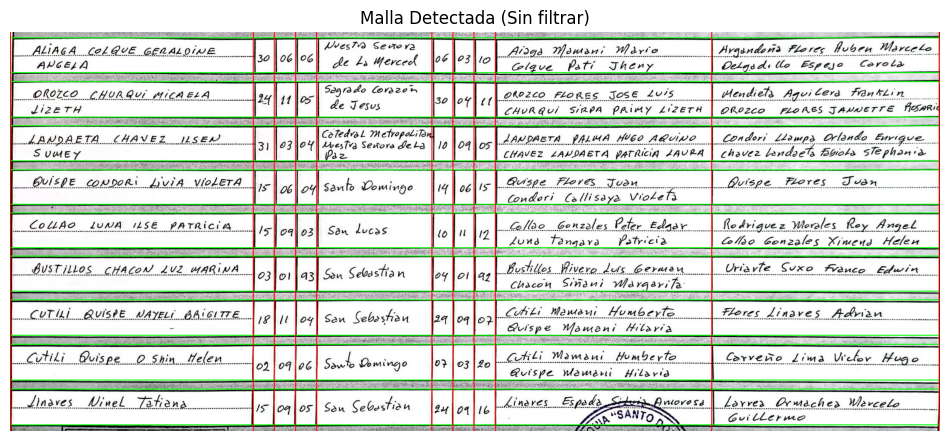


[PASO 3] LECTURA Y FILTRADO DE FILAS VACÍAS
  ▶ Analizando segmento 0... ✅ VÁLIDA (Fila 1)
  ▶ Analizando segmento 1... ❌ VACÍA (Ignorada)
  ▶ Analizando segmento 2... ✅ VÁLIDA (Fila 2)
  ▶ Analizando segmento 3... ❌ VACÍA (Ignorada)
  ▶ Analizando segmento 4... ✅ VÁLIDA (Fila 3)
  ▶ Analizando segmento 5... ❌ VACÍA (Ignorada)
  ▶ Analizando segmento 6... ✅ VÁLIDA (Fila 4)
  ▶ Analizando segmento 7... ❌ VACÍA (Ignorada)
  ▶ Analizando segmento 8... ✅ VÁLIDA (Fila 5)
  ▶ Analizando segmento 9... ❌ VACÍA (Ignorada)
  ▶ Analizando segmento 10... ✅ VÁLIDA (Fila 6)
  ▶ Analizando segmento 11... ❌ VACÍA (Ignorada)
  ▶ Analizando segmento 12... ✅ VÁLIDA (Fila 7)
  ▶ Analizando segmento 13... ❌ VACÍA (Ignorada)
  ▶ Analizando segmento 14... ✅ VÁLIDA (Fila 8)
  ▶ Analizando segmento 15... ❌ VACÍA (Ignorada)
  ▶ Analizando segmento 16... ✅ VÁLIDA (Fila 9)

✅ PROCESO COMPLETADO. Filas reales encontradas: 9


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [4]:
# @title 3. Ejecución con Filtrado de Filas
def run_smart_filter():
    print("=======================================================")
    print("       SISTEMA HTR v9 (FILTRO DE CONTENIDO REAL)       ")
    print("=======================================================")

    print("\n[PASO 1] CARGA DE IMAGEN")
    uploaded = files.upload()
    if not uploaded: return
    fn = list(uploaded.keys())[0]
    img = cv2.imread(fn)

    # SIN ROTACIÓN (Tal como pediste)

    # Inicialización
    dataset_mgr = DatasetManager()
    ocr = HTREngine()
    grid = GridEngine()

    # Grid
    print("\n[PASO 2] DETECCIÓN DE ESTRUCTURA")
    ys, xs = grid.get_structure(img)
    print(f"📊 Líneas detectadas: {len(ys)-1} (Incluye posibles filas vacías)")

    # Visualización Grid
    debug_img = img.copy()
    for y in ys: cv2.line(debug_img, (0, y), (img.shape[1], y), (0, 255, 0), 2)
    for x in xs: cv2.line(debug_img, (x, 0), (x, img.shape[0]), (0, 0, 255), 2)
    plt.figure(figsize=(12, 6))
    plt.title("Malla Detectada (Sin filtrar)")
    plt.imshow(cv2.cvtColor(debug_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

    # Procesamiento y Filtrado
    print("\n[PASO 3] LECTURA Y FILTRADO DE FILAS VACÍAS")

    col_types = {}
    img_width = img.shape[1]
    for i in range(len(xs)-1):
        width = xs[i+1] - xs[i]
        if width < img_width * 0.085: col_types[i] = "date"
        elif 3 <= i <= 6 and width > img_width * 0.1: col_types[i] = "place"
        else: col_types[i] = "text"

    data = []
    start_row = 1 if len(ys) > 1 and (ys[1]-ys[0] < 60) else 0

    # Contador de filas REALES (con datos)
    real_row_idx = 1

    for i in range(start_row, len(ys)-1):
        y1, y2 = ys[i], ys[i+1]
        if y2 - y1 < 20: continue

        # Contenedor temporal de fila
        temp_row = []
        valid_chars = 0 # Contador de "tinta útil"

        print(f"  ▶ Analizando segmento {i}...", end=" ")

        for j in range(len(xs)-1):
            x1, x2 = xs[j], xs[j+1]
            cell = img[y1+2:y2-2, x1+2:x2-2] # Márgenes pequeños

            c_type = col_types.get(j, "text")
            text = ocr.process_cell(cell, col_type=c_type)

            temp_row.append({
                "col": j+1,
                "tipo": c_type,
                "valor": text
            })

            # Acumulamos longitud de texto encontrado
            valid_chars += len(text.strip())

            # Guardar en Dataset (incluso si luego descartamos la fila, el recorte sirve)
            if text.strip():
                dataset_mgr.save_crop(cell, text, real_row_idx, j+1)

        # --- FILTRO MAESTRO ---
        # Si la fila tiene menos de 3 caracteres en TOTAL, se asume vacía/ruido
        if valid_chars < 3:
            print("❌ VACÍA (Ignorada)")
            continue

        print(f"✅ VÁLIDA (Fila {real_row_idx})")

        # Guardamos la fila como válida
        data.append({
            "fila": real_row_idx,
            "datos": temp_row
        })
        real_row_idx += 1

    print(f"\n✅ PROCESO COMPLETADO. Filas reales encontradas: {len(data)}")

    out_file = fn.split('.')[0] + "_smart_filtered.json"
    with open(out_file, 'w', encoding='utf-8') as f:
        json.dump(data, f, ensure_ascii=False, indent=2)

    files.download(out_file)

if __name__ == "__main__":
    run_smart_filter()